Import necessary libraries

In [1]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt


LOG.propagate = False

**Connect to the board via BLE**

In [33]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2025-02-25 02:07:37,644 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:81:80:25:12:64
2025-02-25 02:07:41,663 | INFO     |: Connected to c0:81:80:25:12:64


**Read Accelerometer**
- read a single instance of accelerometer pitch

In [36]:
ble.send_command(CMD.GET_ACCEL_PITCH, "")
pitch = float(ble.receive_string(ble.uuid['RX_STRING']))
print(f"Measured pitch: {pitch}")

Measured pitch: 2.124


- read a single instance of accelerometer roll

In [37]:
ble.send_command(CMD.GET_ACCEL_ROLL, "")
roll = float(ble.receive_string(ble.uuid['RX_STRING']))
print(f"Measured roll: {roll}")

Measured roll: 4.74


- graph accelerometer data over 5 seconds

In [539]:
timestamps = []
pitch = []
roll = []
def extract_accel_data(uuid, byte_array):
    string = byte_array.decode("utf-8") 
    split_str = string.split("|")
    timestamps.append(int(split_str[0]))
    pitch.append(float(split_str[1]))
    roll.append(float(split_str[2]))
    
ble.start_notify(ble.uuid['RX_STRING'], extract_accel_data)
# 1 for low pass, 0 for regular
ble.send_command(CMD.GET_250_ACCEL, "0")


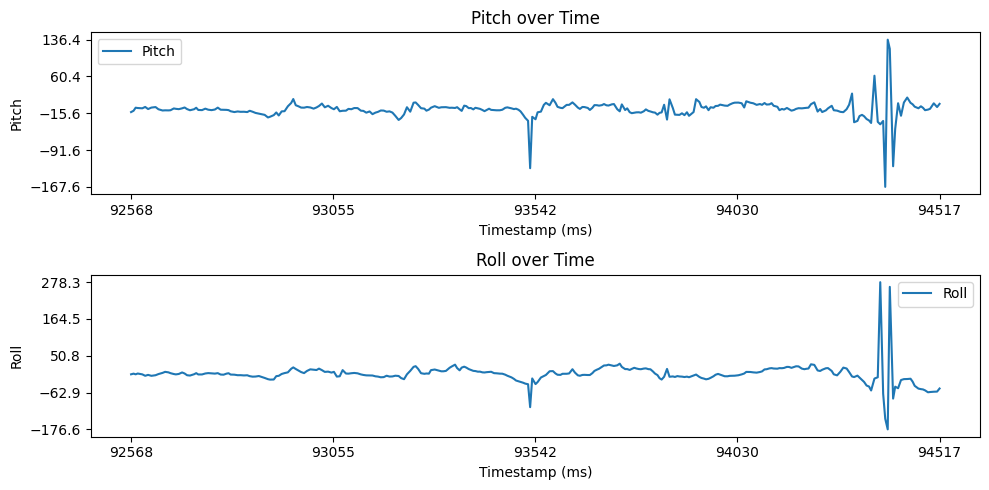

In [488]:
# cast to correct data type
timestamps = np.array(timestamps)
pitch = np.array(pitch)
roll = np.array(roll)

timestamps = timestamps.astype(int)  # Convert all values to float
pitch = pitch.astype(float)      # Convert all values to int (truncates decimals)
roll = roll.astype(float)      # Convert all values to string

plt.figure(figsize=(10, 5))

# Define how many ticks you want
num_ticks = 5  # Adjust this number to control spacing

# First subplot (Pitch)
plt.subplot(2, 1, 1)
plt.plot(timestamps, pitch, label='Pitch')
plt.xlabel('Timestamp (ms)')
plt.ylabel('Pitch')
plt.title('Pitch over Time')
plt.legend()

# Reduce the number of ticks on x and y axes
plt.xticks(np.linspace(min(timestamps), max(timestamps), num_ticks))
plt.yticks(np.linspace(min(pitch), max(pitch), num_ticks))

# Second subplot (Roll)
plt.subplot(2, 1, 2)
plt.plot(timestamps, roll, label='Roll')
plt.xlabel('Timestamp (ms)')
plt.ylabel('Roll')
plt.title('Roll over Time')
plt.legend()

# Reduce the number of ticks on x and y axes
plt.xticks(np.linspace(min(timestamps), max(timestamps), num_ticks))
plt.yticks(np.linspace(min(roll), max(roll), num_ticks))

plt.tight_layout()
plt.show()


In [508]:
ble.stop_notify(ble.uuid['RX_STRING'])

KeyError: 14

**Calibrate Accelerometer**
- perform a two-point calibration for pitch and roll
- hold imu at 90 and -90 degrees and send GET_ACCEL_<PITCH/ROLL>

In [22]:
ble.send_command(CMD.GET_ACCEL_PITCH, "")
n_90_accel_pitch = float(ble.receive_string(ble.uuid['RX_STRING']))
print(f"Accelerometer at -90 degrees pitch: {n_90_accel_pitch}")

Accelerometer at -90 degrees pitch: 0.059


In [28]:
ble.send_command(CMD.GET_ACCEL_PITCH, "")
p_90_accel_pitch = float(ble.receive_string(ble.uuid['RX_STRING']))
print(f"Accelerometer at +90 degrees pitch: {p_90_accel_pitch}")

Accelerometer at +90 degrees pitch: 3.087


In [33]:
ble.send_command(CMD.GET_ACCEL_ROLL, "")
n_90_accel_roll = float(ble.receive_string(ble.uuid['RX_STRING']))
print(f"Accelerometer at -90 degrees roll: {n_90_accel_roll}")

Accelerometer at -90 degrees roll: 0.159


In [34]:
ble.send_command(CMD.GET_ACCEL_ROLL, "")
p_90_accel_roll = float(ble.receive_string(ble.uuid['RX_STRING']))
print(f"Accelerometer at +90 degrees roll: {p_90_accel_roll}")

Accelerometer at +90 degrees roll: 3.114


- find offset by holding imu at 0 degrees

In [35]:
ble.send_command(CMD.GET_ACCEL_PITCH, "")
accel_pitch_offset_raw = float(ble.receive_string(ble.uuid['RX_STRING']))
ble.send_command(CMD.GET_ACCEL_ROLL, "")
accel_roll_offset_raw = float(ble.receive_string(ble.uuid['RX_STRING']))

- calcualte pitch and roll conversion factors

In [17]:
accel_pitch_conversion = 180. / abs(p_90_accel_pitch - n_90_accel_pitch) 
# cast to negative because of how we use arctan2 in low-level code
accel_roll_conversion = -180. / abs(p_90_accel_roll - n_90_accel_roll)

# we need to convert our raw offsets 
accel_pitch_offset =- accel_pitch_offset_raw * accel_pitch_conversion
accel_roll_offset = -accel_roll_offset_raw * accel_roll_conversion

print(f"Accelerometer pitch conversion factor: {accel_pitch_conversion}")
print(f"Accelerometer roll conversion factor: {accel_roll_conversion}")
print(f"Accelerometer pitch offset: {accel_pitch_offset}")
print(f"Accelerometer roll offset: {accel_roll_offset}")


NameError: name 'p_90_accel_pitch' is not defined

- send calibrate command with our calculated conversion and offset values

- typical values that may work:

- Accelerometer pitch conversion factor: 61.41248720573183
Accelerometer roll conversion factor: -60.99627245001694
Accelerometer pitch offset: -95.68065506653019
Accelerometer roll offset: 96.67909183327684

In [35]:
accel_pitch_conversion = 61.41
accel_roll_conversion = -60.99
accel_pitch_offset = -95.68
accel_roll_offset = 96.67
ble.send_command(CMD.CALIBRATE_ACCEL, f"{accel_pitch_conversion}|{accel_roll_conversion}|{accel_pitch_offset}|{accel_roll_offset}")

**Read Gyroscope**

In [39]:
timestamps = []
pitch = []
roll = []
yaw = []
def extract_gyro_data(uuid, byte_array):
    string = byte_array.decode("utf-8") 
    split_str = string.split("|")
    timestamps.append(int(split_str[0]))
    pitch.append(float(split_str[1]))
    roll.append(float(split_str[2]))
    yaw.append(float(split_str[3]))

ble.start_notify(ble.uuid['RX_STRING'], extract_gyro_data)
ble.send_command(CMD.GET_GYROSCOPE_DATA, "") # can use complimentary filter here too

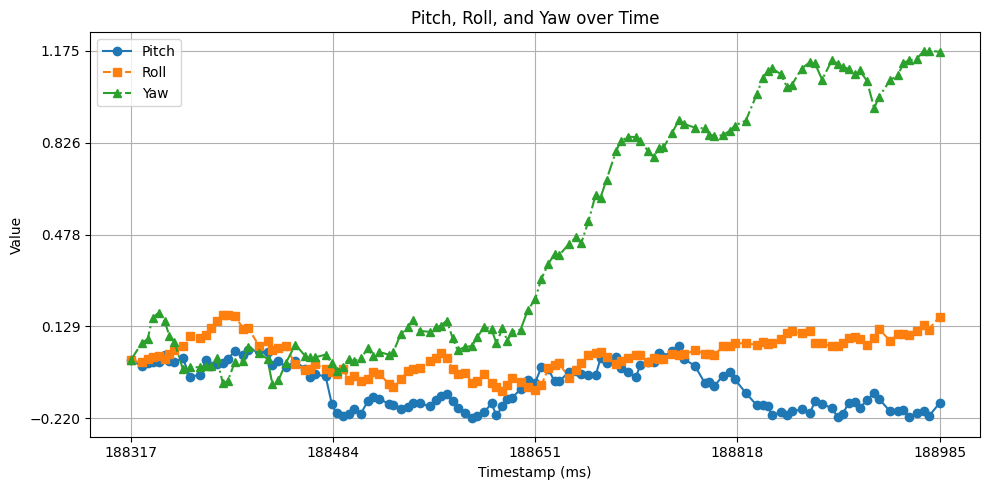

In [40]:
# Cast to correct data type
timestamps = np.array(timestamps, dtype=int)  
pitch = np.array(pitch, dtype=float)      
roll = np.array(roll, dtype=float)      
yaw = np.array(yaw, dtype=float)

plt.figure(figsize=(10, 5))  # Set figure size

# Define how many ticks you want
num_ticks = 5  # Adjust for spacing

# Plot all three lines on the same graph
plt.plot(timestamps, pitch, label='Pitch', linestyle='-', marker='o')
plt.plot(timestamps, roll, label='Roll', linestyle='--', marker='s')
plt.plot(timestamps, yaw, label='Yaw', linestyle='-.', marker='^')

# Labels and title
plt.xlabel('Timestamp (ms)')
plt.ylabel('Value')
plt.title('Pitch, Roll, and Yaw over Time')
plt.legend()

# Reduce the number of ticks on x and y axes
plt.xticks(np.linspace(timestamps.min(), timestamps.max(), num_ticks))
plt.yticks(np.linspace(min(pitch.min(), roll.min(), yaw.min()), 
                       max(pitch.max(), roll.max(), yaw.max()), num_ticks))

plt.grid(True)  # Add grid for readability
plt.tight_layout()
plt.show()


**SAMPLE DATA**
- use start record and stop record commands to collect data for a specified interval

In [38]:
imu_timestamps = []
pitch = []
roll = []
yaw = []

distance1 = []
distance2 = []

def extract_data(uuid, byte_array):
    string = byte_array.decode("utf-8") 
    split_str = string.split("|")
    imu_timestamps.append(int(split_str[0]))
    pitch.append(float(split_str[1]))
    roll.append(float(split_str[2]))
    yaw.append(float(split_str[3]))
    distance1.append(int(split_str[4]))
    distance2.append(int(split_str[5]))
    

ble.start_notify(ble.uuid['RX_STRING'], extract_data)
ble.send_command(CMD.START_RECORD, "") 

In [39]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [40]:
ble.send_command(CMD.STOP_RECORD, "")

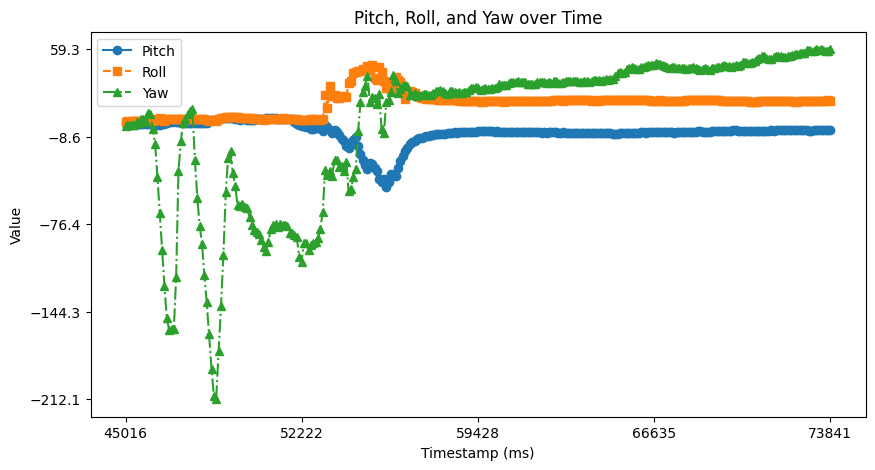

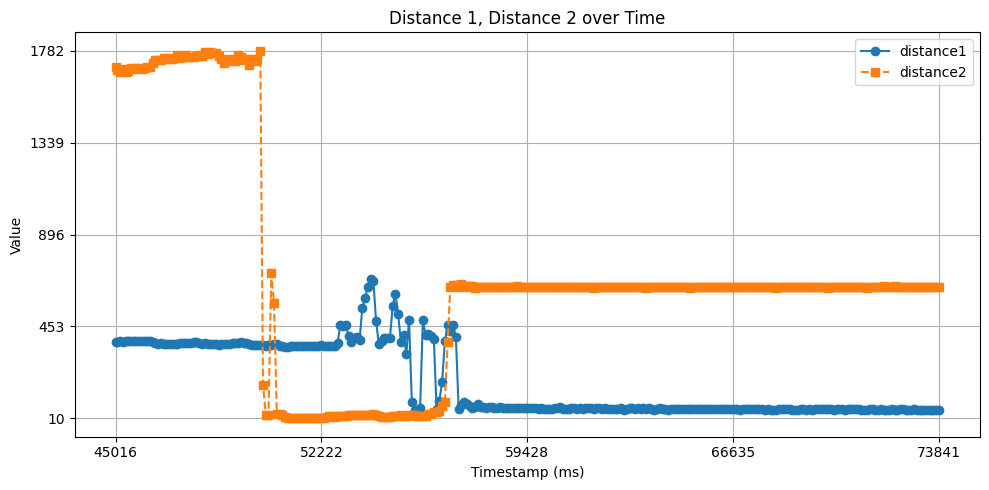

2025-02-25 02:17:21,835 | INFO     |: Disconnected from C0:81:80:25:12:64


In [42]:
# Cast to correct data type
imu_timestamps = np.array(imu_timestamps, dtype=int)  
pitch = np.array(pitch, dtype=float)      
roll = np.array(roll, dtype=float)      
yaw = np.array(yaw, dtype=float)

plt.figure(figsize=(10, 5))  # Set figure size

# Define how many ticks you want
num_ticks = 5  # Adjust for spacing

# Plot all three lines on the same graph
plt.plot(imu_timestamps, pitch, label='Pitch', linestyle='-', marker='o')
plt.plot(imu_timestamps, roll, label='Roll', linestyle='--', marker='s')
plt.plot(imu_timestamps, yaw, label='Yaw', linestyle='-.', marker='^')

# Labels and title
plt.xlabel('Timestamp (ms)')
plt.ylabel('Value')
plt.title('Pitch, Roll, and Yaw over Time')
plt.legend()

# Reduce the number of ticks on x and y axes
plt.xticks(np.linspace(imu_timestamps.min(), imu_timestamps.max(), num_ticks))
plt.yticks(np.linspace(min(pitch.min(), roll.min(), yaw.min()), 
                       max(pitch.max(), roll.max(), yaw.max()), num_ticks))

tof_timestamps = np.array(tof_timestamps, dtype=int)  
distance1 = np.array(distance1, dtype=int)      
distance2 = np.array(distance2, dtype=int)      

plt.figure(figsize=(10, 5))  # Set figure size

# Define how many ticks you want
num_ticks = 5  # Adjust for spacing

# Plot all three lines on the same graph
plt.plot(imu_timestamps, distance1, label='distance1', linestyle='-', marker='o')
plt.plot(imu_timestamps, distance2, label='distance2', linestyle='--', marker='s')

# Labels and title
plt.xlabel('Timestamp (ms)')
plt.ylabel('Value')
plt.title('Distance 1, Distance 2 over Time')
plt.legend()

# Reduce the number of ticks on x and y axes
plt.xticks(np.linspace(imu_timestamps.min(), imu_timestamps.max(), num_ticks))
plt.yticks(np.linspace(min(distance1.min(), distance2.min()), 
                       max(distance1.max(), distance2.max()), num_ticks))

plt.grid(True)  # Add grid for readability
plt.tight_layout()
plt.show()

# plt.grid(True)  # Add grid for readability
# plt.tight_layout()
# plt.show()


**TOF**


Read from TOF1

In [97]:
ble.send_command(CMD.GET_TOF1, "")
distance1 = int(ble.receive_string(ble.uuid['RX_STRING']))
print(f"Measured distance: {distance1}")

Measured distance: 24


Read from TOF2

In [100]:
ble.send_command(CMD.GET_TOF2, "")
distance2 = int(ble.receive_string(ble.uuid['RX_STRING']))
print(f"Measured distance: {distance2}")

Measured distance: 434


READ N TOF entries

In [9]:
tof_timestamps = []
distance1 = []
distance2 = []
def extract_distance_data(uuid, byte_array):
    string = byte_array.decode("utf-8") 
    split_str = string.split("|")
    tof_timestamps.append(int(split_str[0]))
    distance1.append(int(split_str[1]))
    distance2.append(int(split_str[2]))
ble.start_notify(ble.uuid['RX_STRING'], extract_distance_data)
ble.send_command(CMD.GET_TOF_300, "") 

In [10]:
ble.stop_notify(ble.uuid['RX_STRING'])

Plot Raw Data

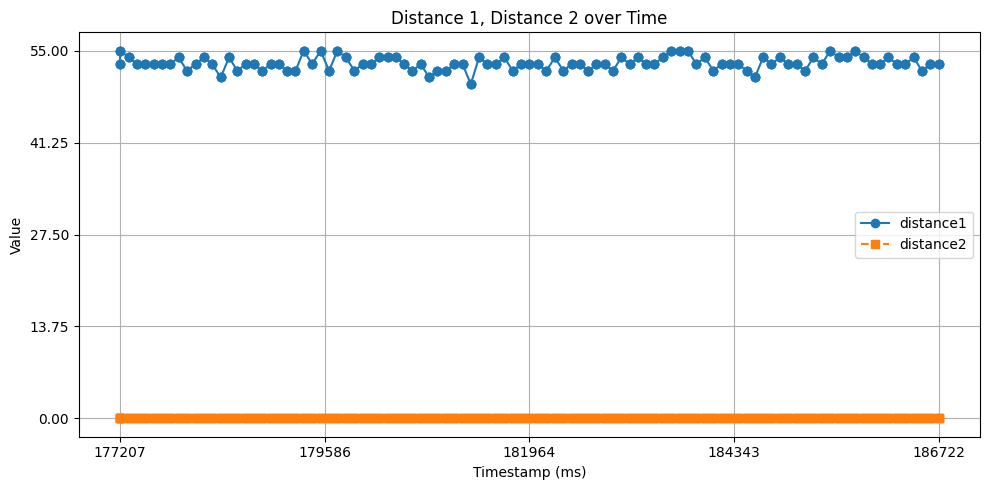

In [9]:
# Cast to correct data type
tof_timestamps = np.array(tof_timestamps, dtype=int)  
distance1 = np.array(distance1, dtype=int)      
distance2 = np.array(distance2, dtype=int)      

plt.figure(figsize=(10, 5))  # Set figure size

# Define how many ticks you want
num_ticks = 5  # Adjust for spacing

# Plot all three lines on the same graph
plt.plot(tof_timestamps, distance1, label='distance1', linestyle='-', marker='o')
plt.plot(tof_timestamps, distance2, label='distance2', linestyle='--', marker='s')

# Labels and title
plt.xlabel('Timestamp (ms)')
plt.ylabel('Value')
plt.title('Distance 1, Distance 2 over Time')
plt.legend()

# Reduce the number of ticks on x and y axes
plt.xticks(np.linspace(tof_timestamps.min(), tof_timestamps.max(), num_ticks))
plt.yticks(np.linspace(min(distance1.min(), distance2.min()), 
                       max(distance1.max(), distance2.max()), num_ticks))

plt.grid(True)  # Add grid for readability
plt.tight_layout()
plt.show()

Calculate Average Distance, Ranging Time, Standard deviation

In [11]:
distance1_avg = np.mean(distance1)
average_diff_ms = np.mean(np.diff(tof_timestamps))
std_dev = np.std(distance1)

print(f"distance1 avg: {distance1_avg}")
print(f"ranging time: {average_diff_ms}")
print(f"Standard Deviation: {std_dev:.4f}")


distance1 avg: 3111.79
ranging time: 95.18181818181819
Standard Deviation: 3.7021
2025-02-24 23:53:00,176 | INFO     |: Disconnected from C0:81:80:25:12:64


Plotting distance, ranging time, std dev

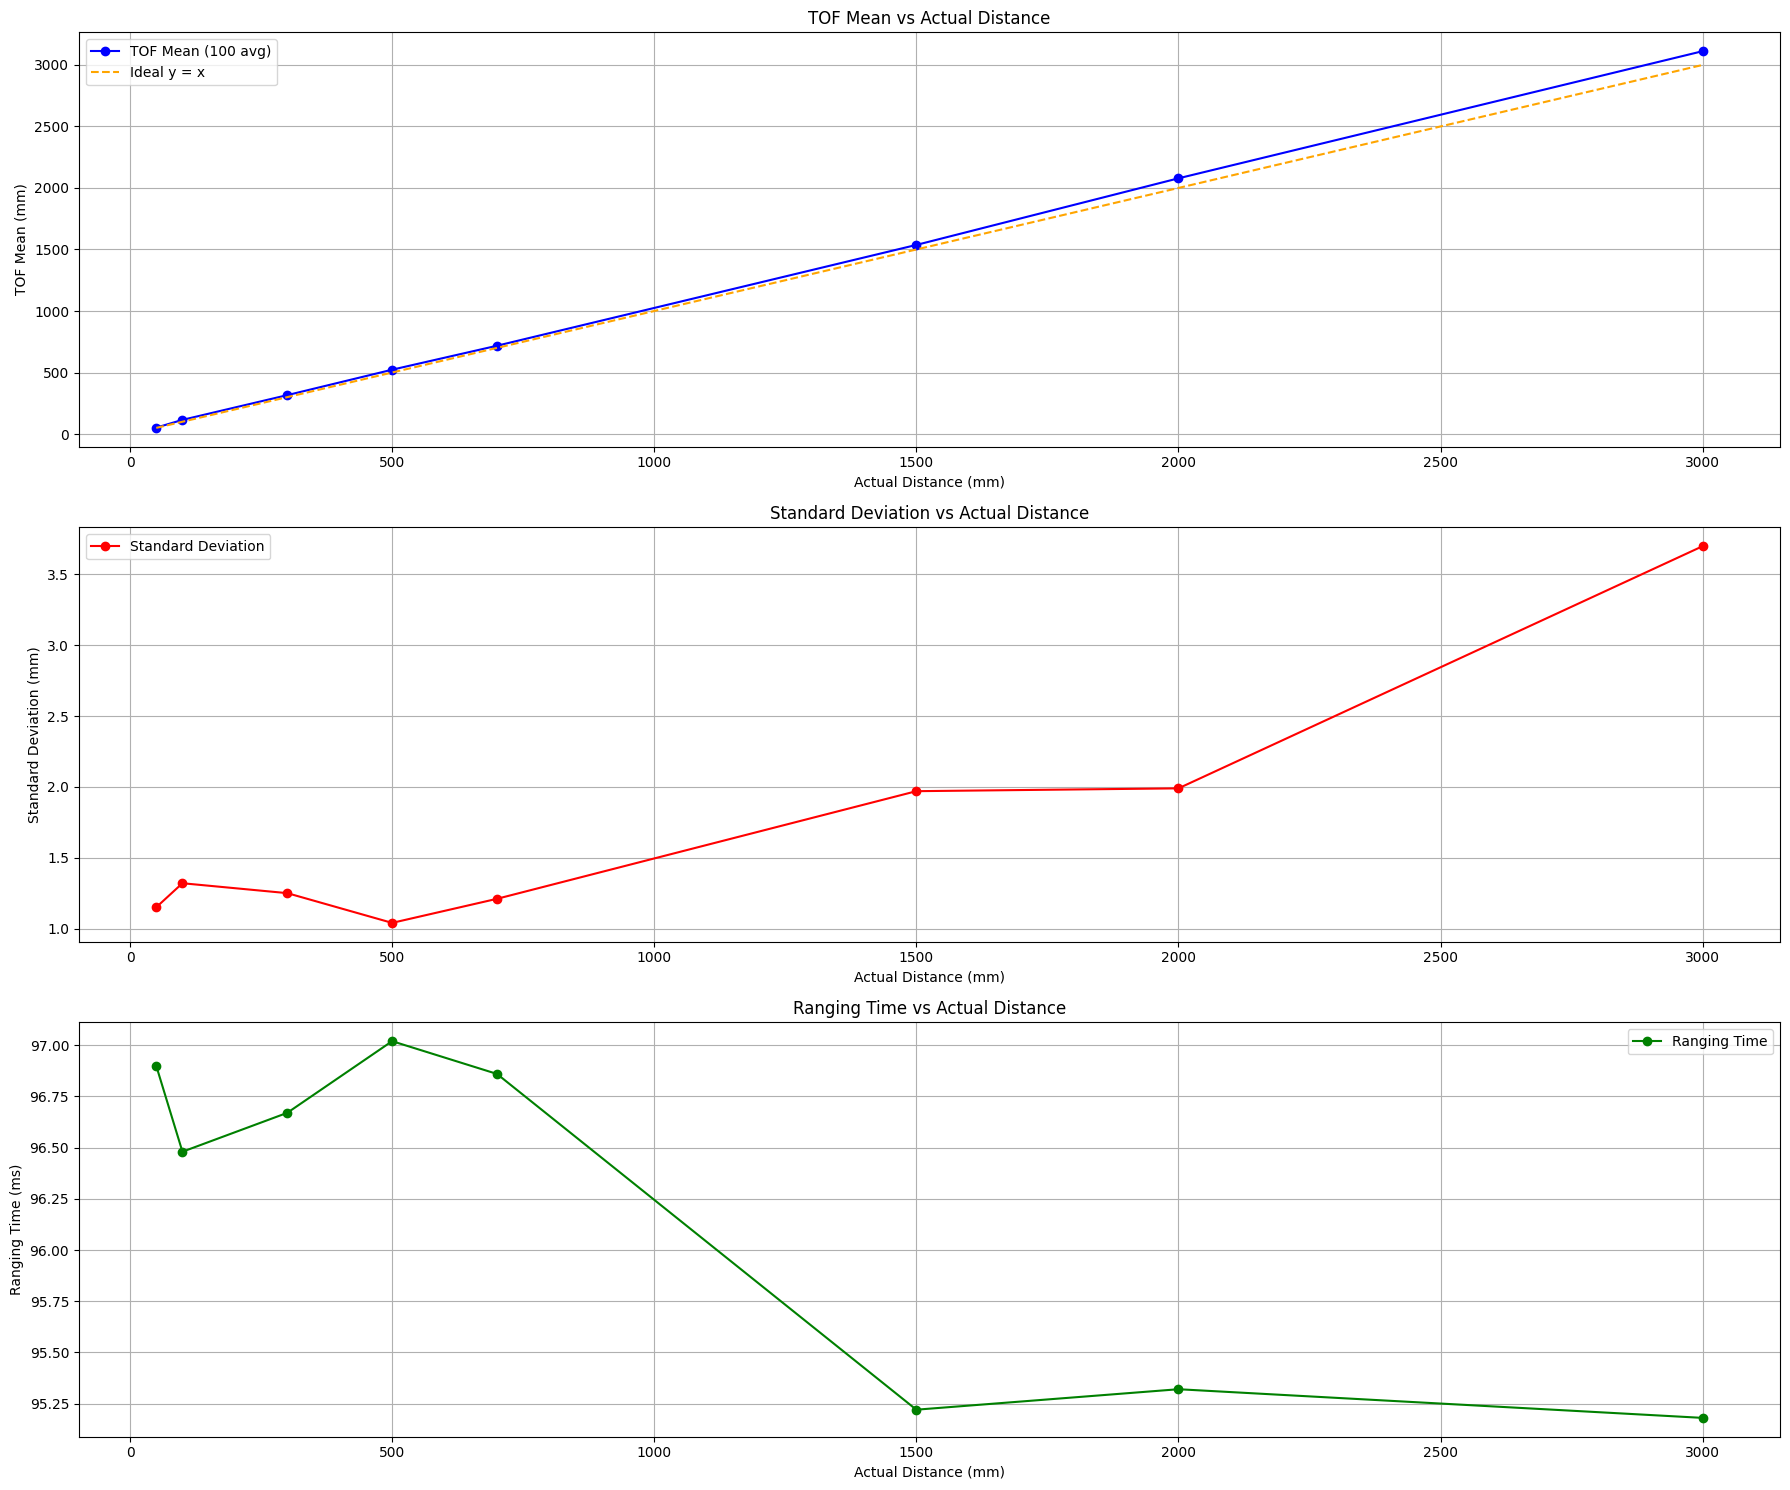

In [14]:
# Data from the table
actual_distance = np.array([50, 100, 300, 500, 700, 1500, 2000, 3000])  # in mm
tof_mean = np.array([52.0, 115.11, 316.18, 522.89, 717.57, 1537.04, 2078.4, 3111.79])  # short distance (100 avg)
ranging_time = np.array([96.90, 96.48, 96.67, 97.02, 96.86, 95.22, 95.32, 95.18])  # in ms
std_deviation = np.array([1.15, 1.32, 1.25, 1.04, 1.21, 1.97, 1.99, 3.70])  # in mm

# Create subplots
plt.figure(figsize=(18, 15))

# Plot 1: TOF Mean with y = x line
plt.subplot(3, 1, 1)
plt.plot(actual_distance, tof_mean, marker='o', color='b', label='TOF Mean (100 avg)')
plt.plot(actual_distance, actual_distance, linestyle='--', color='orange', label='Ideal y = x')
plt.xlabel('Actual Distance (mm)')
plt.ylabel('TOF Mean (mm)')
plt.title('TOF Mean vs Actual Distance')
plt.grid(True)
plt.legend()

# Plot 2: Standard Deviation
plt.subplot(3, 1, 2)
plt.plot(actual_distance, std_deviation, marker='o', color='r', label='Standard Deviation')
plt.xlabel('Actual Distance (mm)')
plt.ylabel('Standard Deviation (mm)')
plt.title('Standard Deviation vs Actual Distance')
plt.grid(True)
plt.legend()

# Plot 3: Ranging Time
plt.subplot(3, 1, 3)
plt.plot(actual_distance, ranging_time, marker='o', color='g', label='Ranging Time')
plt.xlabel('Actual Distance (mm)')
plt.ylabel('Ranging Time (ms)')
plt.title('Ranging Time vs Actual Distance')
plt.grid(True)
plt.legend()

# Display plots
plt.tight_layout()
plt.show()